In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.notebook_utils import setup_notebook_logging
setup_notebook_logging()

In [2]:
from hydra import compose, initialize

with initialize(config_path="./configs", version_base=None):
    cfg = compose(config_name="config")

In [41]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
indices = [i for i, label in enumerate(mnist.targets) if label == 5]
mnist_fives = torch.utils.data.Subset(mnist, indices)

dataloader = DataLoader(mnist_fives, batch_size=3, shuffle=True)

In [ ]:
import torch
import torch.optim as optim

from gan import Generator
LATENT_DIM = cfg.latent_dim

user_ratings = [0.2, 0.8, 0.5, 0.1, 0.9]
human_scores = torch.tensor(user_ratings, dtype=torch.float16)


# Load MNIST for real samples
dataloader = DataLoader(mnist, batch_size=4, shuffle=True)

# Get a batch of real images for display
# real_iter = iter(dataloader)
# real_images, _ = next(real_iter)



In [78]:
from gan import Generator
generator = Generator(latent_dim=LATENT_DIM)
optimiser_G = optim.AdamW(generator.parameters(), lr=0.0002)

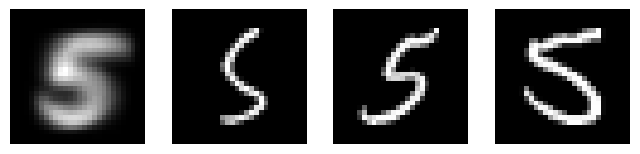

In [127]:
import random
import matplotlib.pyplot as plt

real_imgs = []
for i, (img, _) in enumerate(dataloader):
    real_imgs.extend(img)
    if len(real_imgs) >= 3:
        break
real_imgs = real_imgs[:3]

gen_img = generator.generate()[1].detach()
all_imgs = real_imgs.copy()
insert_idx = random.randint(0, 3)

all_imgs.insert(insert_idx, gen_img)

plt.figure(figsize=(8, 2))
for i, img in enumerate(all_imgs):
    plt.subplot(1, 4, i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

In [116]:
from tqdm import tqdm
from gan import step_human_round, train_generator_step

num_rounds = 5000

real_iter = iter(dataloader)

for step in range(num_rounds):

    # 1) human round → pick z, reward
    z, reward = step_human_round(generator, dataloader)

    # 2) get a batch of real images for surrogate loss
    try:
        real_batch, _ = next(real_iter)
    except StopIteration:
        real_iter = iter(dataloader)
        real_batch, _ = next(real_iter)

    # 3) update generator
    loss, surr = train_generator_step(generator, optimiser_G, z, reward, real_batch, alpha=1.0)

    if step % 100 == 0:
        print(f"[{step}] loss={loss:.4f}, surr={surr:.4f}, reward={reward}")

[0] loss=0.0440, surr=0.0440, reward=0
[100] loss=0.0760, surr=0.0760, reward=0
[200] loss=0.0747, surr=0.0747, reward=0
[300] loss=0.0713, surr=0.0713, reward=0
[400] loss=0.0839, surr=0.0839, reward=0
[500] loss=0.0910, surr=0.0910, reward=0
[600] loss=0.0855, surr=0.0855, reward=0
[700] loss=0.1080, surr=0.1080, reward=0
[800] loss=0.0485, surr=0.0485, reward=0
[900] loss=0.0936, surr=0.0936, reward=0
[1000] loss=0.0931, surr=0.0931, reward=0
[1100] loss=0.1020, surr=0.1020, reward=0
[1200] loss=0.0664, surr=0.0664, reward=0
[1300] loss=0.0711, surr=0.0711, reward=0
[1400] loss=0.0570, surr=0.0570, reward=0
[1500] loss=0.0520, surr=0.0520, reward=0
[1600] loss=0.0970, surr=0.0970, reward=0
[1700] loss=0.0751, surr=0.0751, reward=0
[1800] loss=0.0875, surr=0.0875, reward=0
[1900] loss=0.0930, surr=0.0930, reward=0
[2000] loss=0.0823, surr=0.0823, reward=0
[2100] loss=0.0790, surr=0.0790, reward=0
[2200] loss=0.1435, surr=0.1435, reward=0
[2300] loss=0.0642, surr=0.0642, reward=0
[240